In [1]:
#Note: this notebook is like graph1, but it will specifically process particular tokens in the loss_per_token_scored.csv file

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statistics
sns.set()
# sns.set_context('paper', font_scale=0.73)
sns.set_context('paper', font_scale=1.3)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
!echo $CONDA_DEFAULT_ENV

In [3]:
#paths
root_dir = "/home/ryan/haveibeentrainedon/models/unstealthy_scaling"
group_folder = "scaling_final"
exp_name= ["pile1e9_40len", "pile2e9_40len", "pile4e9_40len", "pile8e9_40len"]
seeds = ["seed0", "seed1", "seed2"]
model_sizes = ["70M"]
scored_file = "loss_per_token_scored.csv"

#these are the tokens that we will be averaging the losses to get our statistic
start_attend = 0
end_attend = 100

experiments = [f"{root_dir}/{group_folder}/{exp}_{seed}/{model_size}" for model_size in model_sizes for exp in exp_name for seed in seeds]
experiments

['/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile1e9_40len_seed0/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile1e9_40len_seed1/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile1e9_40len_seed2/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile2e9_40len_seed0/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile2e9_40len_seed1/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile2e9_40len_seed2/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile4e9_40len_seed0/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile4e9_40len_seed1/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile4e9_40len_seed2/70M',
 '/home/ryan/haveibeentrainedon/models/unstealthy_scaling/scaling_final/pile8e9_40len_seed0/70M',
 '/home/ryan/haveibe

In [4]:
models = list(filter(lambda x: x[-5:] == "model", os.listdir(experiments[0])))
models = sorted(models, key = lambda x: eval(x[:-6]))
models

['128_model']

In [5]:
def read_file(file_name):
    data = []
    with open(file_name, 'r') as file:
        for line in file:
            row = [eval(element.strip()) for element in line.split(",")]
            data.append(row[start_attend:end_attend])
    return data

In [6]:
experiments_dfs = []
for experiment in experiments:
    model_dfs = []
    for model_type in models:
        model_dfs += [read_file(os.path.join(experiment,  model_type, scored_file))]
    experiments_dfs.append(model_dfs)
print(len(experiments_dfs))
print(len(model_dfs))

12
1


In [7]:

y_axises = []
null_means = []
null_stdev = []
statistic_total = []
for experiment_dfs in experiments_dfs:
    y_axis = []
    null_raw = []
    null_std = []
    statistic_temp = []
    for model_df in experiment_dfs:
        null_raw = model_df[1:]
        #we first average over tokens to get average loss per each example
        null = [statistics.mean(row) for row in null_raw]

        #we then calculate the average and stdev of this null distribution
        mean = statistics.mean(null)
        stdev = statistics.stdev(null)

        statistic = statistics.mean(model_df[0])
        # print(f"statistic = {statistic}, mean = {mean}, stdev = {stdev}")

        statistic_temp += [statistic]

        y_axis += [(statistic - mean) / stdev]
        null_means += [mean]
        null_std += [stdev]
    y_axises.append(y_axis)
    statistic_total.append(statistic_temp)
    null_stdev.append(null_std)

print(len(y_axises[0]))

1


In [8]:
y_axises

[[-5.796694488589017],
 [-7.542380502703906],
 [-8.811937379272988],
 [-5.287568881658938],
 [-6.792899375147598],
 [-9.070368092443701],
 [-2.0721798624456746],
 [-5.203167830859406],
 [-8.131650528834763],
 [-1.138827140429746],
 [-5.142221509924204],
 [-2.99765286007094]]

In [9]:
y_axises = np.array(y_axises).reshape(len(exp_name), -1)
print(y_axises.mean(axis=1))
print(y_axises.std(axis=1))


[-7.38367079 -7.05027878 -5.13566607 -3.0929005 ]
[1.23607281 1.55500816 2.47422898 1.63576602]


In [10]:
print(np.array(null_means).reshape(len(exp_name), -1).mean(axis=1))
print(np.array(null_means).reshape(len(exp_name), -1).std(axis=1))


[6.4814151  6.39876576 6.32438827 6.26249613]
[0. 0. 0. 0.]


In [11]:
print(np.array(null_stdev).reshape(len(exp_name), -1).mean(axis=1))
print(np.array(null_stdev).reshape(len(exp_name), -1).std(axis=1))


[0.29126322 0.27071058 0.27220831 0.26384956]
[0. 0. 0. 0.]


In [12]:
print(np.array(statistic_total).reshape(len(exp_name), -1).mean(axis=1))
print(np.array(statistic_total).reshape(len(exp_name), -1).std(axis=1))


[6.2873119  6.58293931 6.44217108 6.64105118]
[0. 0. 0. 0.]


In [10]:
averaged = np.array(y_axises).mean(axis=0)
averaged

array([-3.57381759, -6.1701673 , -7.25290222])

In [11]:
# x_axis = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
# x_axis=[256]
# x_axis = [70, 160, 410, 1400]
x_axis = [1, 2, 4, 8]
print(x_axis)

[1, 2, 4, 8]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


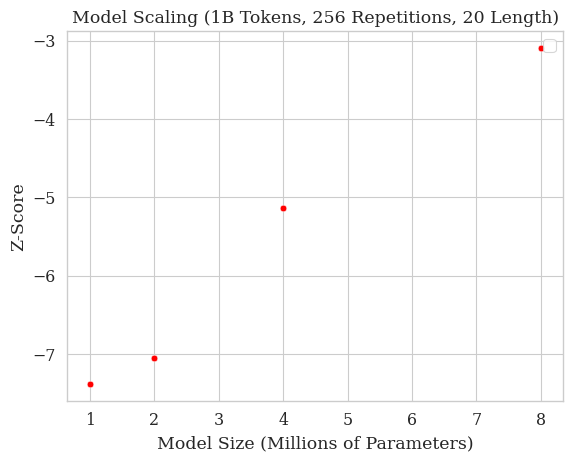

In [12]:
# Create a line plot for each set of y-values
sns.scatterplot(x=x_axis, y=y_axises.mean(axis=1), color='red')

# sns.scatterplot(x=x_axis, y=y_axises[0], color='red', label='70M')
# ax = sns.lineplot(x=x_axis, y=y_axises[1], color='blue', label='160M')
# sns.scatterplot(x=x_axis, y=y_axises[2], color='green', label='30char')

# Customize the plot
plt.title('Model Scaling (1B Tokens, 256 Repetitions, 20 Length)')
plt.xlabel('Model Size (Millions of Parameters)')
plt.ylabel('Z-Score')
plt.legend()

# Show the plot
plt.show()

In [25]:
np.array(y_axises).mean()

-8.709461298761209